In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation,Flatten,MaxPool2D,Conv2D
from keras.optimizers import SGD, Adam, RMSprop
from keras.utils.np_utils import to_categorical
from keras.utils.vis_utils import plot_model
from sklearn.model_selection import train_test_split
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import VotingClassifier
import itertools

C:\Users\Administrator\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [10]:
originPath='C:\\Users\\Administrator\\Desktop\\Kaggle\\Digit Recognizer\\input\\'
train_data = pd.read_csv(originPath+'train.csv')
test_data = pd.read_csv(originPath+'test.csv')

In [11]:
'''查看训练集和测试集的简明摘要'''
train_data.info()
print('_____________________________________________________')
test_data.info()
print('_____________________________________________________')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB
_____________________________________________________
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28000 entries, 0 to 27999
Columns: 784 entries, pixel0 to pixel783
dtypes: int64(784)
memory usage: 167.5 MB
_____________________________________________________


In [12]:
'''查看是否存在缺失值（若存在缺失值，需要对缺失值进行处理）'''
# isnull()判断是否有缺失值；
# any()返回是否有任何元素在请求轴上为真（会将DataFrame转为Series）,若axis=0则以columns为单位，若axis=1则以index为单位,axis默认为0；
# describe()对数据进行描述性统计（对象属性会返回count计数和，unique不重复的值的数量，top最常见的值的value，freq最常见的值的频率）
print(train_data.isnull().any().describe())
print('_____________________________________________________')
print(test_data.isnull().any().describe())
print('_____________________________________________________')

count       785
unique        1
top       False
freq        785
dtype: object
_____________________________________________________
count       784
unique        1
top       False
freq        784
dtype: object
_____________________________________________________


In [13]:
batch_size = 256 # 在计算力允许的情况下，batch_size越大越好
nb_classes = 10
nb_epoch = 30

In [14]:
'''数据预处理'''
X_train=train_data.drop(columns=['label'])
Y_train=train_data.label
del train_data
# 改变维度：第一个参数是图片数量，后三个参数是每个图片的维度
X_train = X_train.values.reshape(-1,28,28,1)
test_data = test_data.values.reshape(-1,28,28,1)
print(X_train.shape)
print(test_data.shape)
print("Train Sample:",X_train.shape[0])
print("Test Sample:",test_data.shape[0])

(42000, 28, 28, 1)
(28000, 28, 28, 1)
Train Sample: 42000
Test Sample: 28000


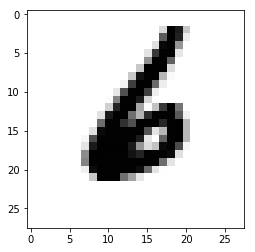

In [15]:
# 归一化：将数据进行归一化到0-1 因为图像数据最大是255
X_train=X_train/255.0
test_data=test_data/255.0
# 将类别向量(从0到nb_classes的整数向量)映射为二值类别矩阵
Y_train = to_categorical(Y_train, num_classes = nb_classes)
X_train,X_val,Y_train,Y_val=train_test_split(X_train,Y_train,test_size=0.1)
plt.imshow(X_train[0][:,:,0], cmap="Greys")
plt.show()


In [18]:
'''建立模型'''
model = Sequential()
# filters：卷积核的数目（即输出的维度）
# kernel_size：卷积核的宽度和长度。如为单个整数，则表示在各个空间维度的相同长度。
model.add(Conv2D(filters = 32, kernel_size = (5,5),activation ='relu', input_shape = (28,28,1)))
model.add(Conv2D(filters = 32, kernel_size = (5,5),activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Dropout(0.25))
model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu'))
model.add(Conv2D(filters = 64, kernel_size = (3,3),activation ='relu'))
model.add(MaxPool2D(pool_size=(2,2), strides=(2,2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(0.5))
model.add(Dense(10, activation = "softmax"))

'''显示模型信息并保存'''
# print(model.summary())
#plot_model(model, to_file='Model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [19]:
'''数据扩增'''
# 用以生成一个batch的图像数据，支持实时数据提升
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=10,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

# 计算依赖于数据的变换所需要的统计信息(均值方差等),
# 只有使用featurewise_center，featurewise_std_normalization或zca_whitening时需要此函数。
# datagen.fit(X_train)

In [20]:
'''学习率的设置'''
# 当评价指标monitor不在提升时，减少学习率
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc',
                                            patience=3,
                                            verbose=1,
                                            factor=0.5,
                                            min_lr=0.00001)

In [21]:
'''编译和训练模型'''
optimizer=RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0)
# 使用多类的对数损失categorical_crossentropy
model.compile(loss='categorical_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])

# history=model.fit(X_train,Y_train,
#           batch_size=batch_size,
#           epochs=nb_epoch,
#           verbose=2,
#           validation_data=(X_val,Y_val))


# ImageDataGenerator需要和fir_generator配合，才能实时进行数据扩增
# 当生成器返回steps_per_epoch次数据时计一个epoch结束，执行下一个epoch
history = model.fit_generator(datagen.flow(X_train,Y_train, batch_size=batch_size),
                              epochs =nb_epoch, validation_data = (X_val,Y_val),
                              verbose = 2, steps_per_epoch=X_train.shape[0] // batch_size+1,
                              callbacks=[learning_rate_reduction])


Epoch 1/30
 - 291s - loss: 0.8747 - acc: 0.7129 - val_loss: 0.1249 - val_acc: 0.9607
Epoch 2/30
 - 262s - loss: 0.3016 - acc: 0.9083 - val_loss: 0.0695 - val_acc: 0.9795
Epoch 3/30
 - 258s - loss: 0.1905 - acc: 0.9423 - val_loss: 0.0579 - val_acc: 0.9826
Epoch 4/30
 - 291s - loss: 0.1454 - acc: 0.9563 - val_loss: 0.0498 - val_acc: 0.9862
Epoch 5/30
 - 296s - loss: 0.1231 - acc: 0.9632 - val_loss: 0.0485 - val_acc: 0.9862
Epoch 6/30
 - 389s - loss: 0.1051 - acc: 0.9685 - val_loss: 0.0418 - val_acc: 0.9860
Epoch 7/30
 - 283s - loss: 0.0961 - acc: 0.9719 - val_loss: 0.0316 - val_acc: 0.9902
Epoch 8/30
 - 260s - loss: 0.0871 - acc: 0.9739 - val_loss: 0.0301 - val_acc: 0.9914
Epoch 9/30
 - 259s - loss: 0.0818 - acc: 0.9751 - val_loss: 0.0406 - val_acc: 0.9876
Epoch 10/30
 - 305s - loss: 0.0761 - acc: 0.9772 - val_loss: 0.0317 - val_acc: 0.9912
Epoch 11/30
 - 281s - loss: 0.0727 - acc: 0.9783 - val_loss: 0.0258 - val_acc: 0.9907

Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.000

In [22]:
'''评估模型'''
score = model.evaluate(X_val, Y_val, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.01680805557435157
Val accuracy: 0.9959523809523809


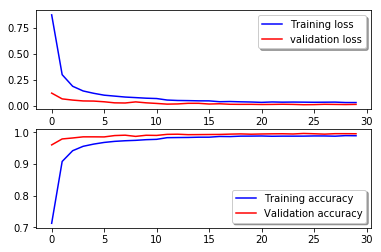

In [23]:
'''绘制学习曲线'''
fig, ax = plt.subplots(2,1)
ax[0].plot(history.history['loss'], color='b', label="Training loss")
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0])
ax[0].legend(loc='best', shadow=True)
ax[1].plot(history.history['acc'], color='b', label="Training accuracy")
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax[1].legend(loc='best', shadow=True)
plt.show()

In [24]:
'''预测测试集'''
print('Begin to predict for testing data ...')
results = model.predict(test_data)
results = np.argmax(results,axis = 1)
results = pd.Series(results,name="Label")
submission = pd.concat([pd.Series(range(1,28001),name = "ImageId"),results],axis = 1)
submission.to_csv(originPath+"submit.csv",index=False)

Begin to predict for testing data ...


In [ ]:
model.save('model.h5')

In [ ]:
optimizer = RMSprop(lr=0.001, rho=0.9, epsilon=1e-08, decay=0.0) # 使用多类的对数损失categorical_crossentropy 
model.compile(loss='categorical_crossentropy', 
              optimizer=optimizer, 
              metrics=['accuracy']) 
history = model.fit(X_train,Y_train, 
                    batch_size=batch_size, 
                    epochs=nb_epoch, 
                    verbose=2, 
                    validation_data=(X_val,Y_val))


In [ ]:
#评估model
score = model.evaluate(X_val, Y_val, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

In [ ]:
#绘制学习曲线
fig, ax = plt.subplots(2,1) 
ax[0].plot(history.history['loss'], color='b', label="Training loss") 
ax[0].plot(history.history['val_loss'], color='r', label="validation loss",axes =ax[0]) 
ax[0].legend(loc='best', shadow=True) ax[1].plot(history.history['acc'], color='b', label="Training accuracy") 
ax[1].plot(history.history['val_acc'], color='r',label="Validation accuracy") 
ax[1].legend(loc='best', shadow=True) plt.show()